In [1]:
from CosinorPy import file_parser, cosinor, cosinor1
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import matplotlib.patches as mpl_patches

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'
sns.set(style='whitegrid')

In [3]:
metadata = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/metadata_all_col.csv', low_memory = False, index_col = "sample_id")
phylum = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/phylum.csv', index_col = 'Unnamed: 0', low_memory = False)
family = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/family.csv', index_col = 'Unnamed: 0', low_memory = False)
asv = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/asv.csv', index_col = 'Unnamed: 0', low_memory = False)

## Sample Distributions

In [4]:
mycounts = metadata.groupby(by='col_bin').agg('count').astype(int).reset_index()
mycounts2 = metadata.groupby(by='month').agg('count').astype(int).reset_index()

[Text(0, 0, '0-2am'),
 Text(0, 0, '2-4am'),
 Text(0, 0, '4-6am'),
 Text(0, 0, '6-8am'),
 Text(0, 0, '8-10am'),
 Text(0, 0, '10-noon'),
 Text(0, 0, '12-2pm'),
 Text(0, 0, '2-4pm'),
 Text(0, 0, '4-6pm'),
 Text(0, 0, '6-8pm'),
 Text(0, 0, '8-10pm'),
 Text(0, 0, '10-MN')]

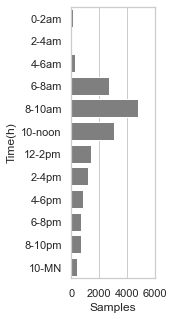

In [5]:
fig, ax = plt.subplots(figsize = (1.5,5))
ax  = sns.barplot(x = mycounts['body_habitat'], y = mycounts.col_bin.astype(str), color = sns.color_palette("tab10")[7])
plt.ylabel('Time(h)')
plt.xlabel('Samples')
plt.tick_params(left=False, bottom=False)
xticks = [0,2000,4000,6000]
ax.set_xticks(xticks)
ax.set_yticklabels(['0-2am','2-4am','4-6am', '6-8am','8-10am','10-noon','12-2pm','2-4pm','4-6pm','6-8pm','8-10pm','10-MN'])
#plt.savefig('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/figures/fig1bp1.csv', format = 'svg')

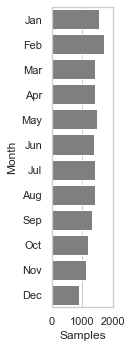

In [6]:
fig, ax = plt.subplots(figsize = (2,5))
ax = sns.barplot(x = mycounts2['body_habitat'], y = mycounts2.month.astype(str),color = sns.color_palette("tab10")[7])
plt.ylabel('Month')
plt.xlabel('Samples')
plt.tick_params(left=False, bottom=False)
ax.set_yticklabels(['Jan','Feb','Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
xticks2 = [0,1000,2000]
ax.set_xticks(xticks2)
plt.tight_layout()
#plt.savefig('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/figures/fig1bp1.csv', format = 'svg')

## Heatmap of Rhythmic ASVs

In [7]:
#Selecting rhythmic asvs
results = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/results/asv.csv', index_col = 'test')
results = results[results.q<0.05]

In [8]:
#filtering and sorting clr table
filt_asv = (
    asv.T[asv.columns.isin(results.index)]
    .join(results['acrophase[h]'])
    .sort_values(by='acrophase[h]')
    .drop(columns='acrophase[h]')
)

In [9]:
#create a 4hr bin column
metadata['col_bin_2'] = (metadata['hour'] // 4 * 4 + 2).astype(int)

In [10]:
#creating pivot table
comb = filt_asv.T.join(metadata.col_bin_2)
combagg = comb.astype(float).groupby('col_bin_2').agg('mean')

In [11]:
# Normalization
c = (combagg - combagg.min()) / (combagg.max() - combagg.min())

# Reorder rows of pivot table by acrophase
order = [2.0, 6.0, 10.0, 14.0, 18.0, 22.0]
tot = pd.concat([c.T[c.T[bin_val] == 1] for bin_val in order])

Text(28.4, 0.5, 'Rhythmic ASVs')

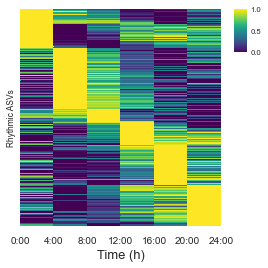

In [12]:
sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(3.6, 4))
cbar_ax = fig.add_axes([.950, 0.73, .05, .15])
g = sns.heatmap(tot, ax=ax, cbar_ax=cbar_ax, cmap='viridis', cbar=True, yticklabels=False)
g.tick_params(labelsize=10)
ax.set_xticklabels(['0:00', '4:00', '8:00', '12:00', '16:00', '20:00', '24:00'])
ax.tick_params(left=False, bottom=False)
ax.set_xticks(np.linspace(0, 6, 7))
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.ax.tick_params(size=0)
ax.set_xlabel('Time (h)', fontsize=13)
ax.set_ylabel('Rhythmic ASVs')

## Regression Plots

In [13]:
#Import bloom data
phylumb = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/bloom/phylum.csv', index_col = 'Unnamed: 0', low_memory = False)
familyb = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/bloom/family.csv', index_col = 'Unnamed: 0', low_memory = False)
metab = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/bloom/metadata_all_col.csv', index_col = 'sample_id', low_memory = False)

In [14]:
jp1 = phylum.join(metadata.col_bin).dropna()
jp2 = phylumb.join(metab.col_bin).dropna()

jf1 = family.join(metadata.col_bin).dropna()
jf2 = familyb.join(metab.col_bin).dropna()

In [15]:
def skeletonbloom(joint_file1, joint_file2, taxa):
    sns.set_style("whitegrid", {'axes.grid': False})
    
    def prepare_data(joint_file, taxa):
        joint_file['col_bin'] = joint_file['col_bin'].astype(float)
        joint_file[taxa] = joint_file[taxa].dropna().astype(float)
        melted = pd.melt(joint_file, id_vars='col_bin')
        melted.rename(columns={'col_bin': 'x', 'value': 'y', 'variable': 'test'}, inplace=True)
        return melted[melted.test == taxa]
    
    taxa_of_interest1 = prepare_data(joint_file1, taxa)
    taxa_of_interest2 = prepare_data(joint_file2, taxa)
    
    # Performing regression
    info1 = cosinor1.fit_cosinor(X=taxa_of_interest1.x, Y=taxa_of_interest1.y, period=24, test='test', save_to='test', plot_on=True)
    cosinor_results1 = cosinor1.fit_group(taxa_of_interest1, period=[24], plot_on=False)

    info2 = cosinor1.fit_cosinor(X=taxa_of_interest2.x, Y=taxa_of_interest2.y, period=24, test='test', save_to='test', plot_on=True)
    cosinor_results2 = cosinor1.fit_group(taxa_of_interest2, period=[24], plot_on=False)
        
    x = np.arange(1, 24, 1)
    color1 = sns.color_palette()[1]
    color2 = sns.color_palette()[0]

    z1 = cosinor_results1.amplitude[0] * np.cos(np.pi/12 * x + cosinor_results1.acrophase[0]) + info1[3]['values'][0]
    z2 = cosinor_results2.amplitude[0] * np.cos(np.pi/12 * x + cosinor_results2.acrophase[0]) + info2[3]['values'][0]
    
    fig, ax = plt.subplots(figsize=(5, 3))
    
    sns.lineplot(data=joint_file1, x="col_bin", y=taxa, alpha=1, err_style='bars', linestyle='', color=color1, ax=ax)
    scatdat1 = joint_file1[['col_bin', taxa]].groupby('col_bin').agg('mean').reset_index()
    e = ax.scatter(scatdat1.col_bin, scatdat1[taxa], color=color1, label='Without Blooms')
    
    sns.lineplot(data=joint_file2, x="col_bin", y=taxa, alpha=1, err_style='bars', linestyle='', color=color2, ax=ax)
    scatdat2 = joint_file2[['col_bin', taxa]].groupby('col_bin').agg('mean').reset_index()
    f = ax.scatter(scatdat2.col_bin, scatdat2[taxa], color=color2, label='With Blooms')

    ax.set_xlabel('Time (h)')
    ax.set_ylabel('CLR')

    if len(joint_file2.columns) > 20:
        tax_short = taxa[taxa.find('f__') + 3:]
        desig = 'Family/'
    else:
        tax_short = taxa.replace('d__Bacteria;p__', '')
        desig = 'Phylum/'
    
    scientific_notation = "{:e}".format(cosinor_results1.q[0])
    pval = 'p* = ' + scientific_notation[:4] + scientific_notation[-4:]
    ax.set_title(tax_short, fontsize=13)
    
    if cosinor_results1.q[0] < 0.05:
        ax.plot(x, z1, color=color1, label=pval)
    if cosinor_results2.q[0] < 0.05:
        ax.plot(x, z2, color=color2, label=pval)

    legend2 = ax.legend([e, f], ['Without Blooms', 'With Blooms'], loc=(1.05, 0.5))
    handles = [mpl_patches.Rectangle((0, 0), 3, 3, fc="white", ec="white", lw=0, alpha=0)] * 2
    labels = [pval]
    legend1 = ax.legend(handles, labels, loc=(1.05, 0.863), fontsize='medium', fancybox=True, framealpha=0.7, handlelength=0, handletextpad=0)
    ax.add_artist(legend2)
    ax.add_artist(legend1)

    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/figures/line_graphs/{desig}bloom/{tax_short}.svg', bbox_inches="tight", format='svg')
    
    return fig, ax, pval

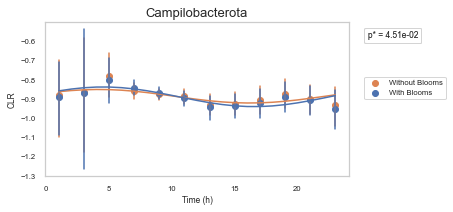

In [16]:
for i in range(len(phylum.columns)):
    skeletonbloom(jp1,jp2, phylum.columns[i])

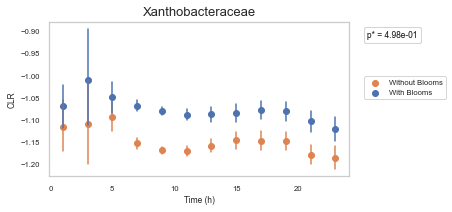

In [17]:
for i in range(len(family.columns)):
    skeletonbloom(jf1,jf2, family.columns[i])